# 022_MC_blackjack_control
## Suntton p.101 
### On-Policy First-Visit MC control(for e-soft policies) for optimum policy pi*

<img src="https://t1.daumcdn.net/cfile/tistory/9985DE425C7C66AD28" width=600 />

## policy 를 개선하여 optimal policy를 찾기 위한 알고리즘 

- e-soft policy $\pi$, state-action value Q(s, a) 를 random 하게 초기화   

- 각 state-action pair  로 부터의 return 을 저장할 Returns(s, a) empty list 생성  

- Policy $\pi$ 를 이용하여 episode 생성
- 각 state-action pair 에 대해, first occurrence 이후의 return 들을 더함. Q(s, a) = first occurrence 이후의 모든 return 의 평균.
- 각 state 에 대하여 Policy 가 해당 state 의 가장 valuable 한 action을 선택할 확률 증가시킴

In [6]:
import gym 
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

#state : (player card sum, dealer open card, usable_ace 보유) ex) (6, 1, False)
win_cnt = 0
lose_cnt = 0
draw_cnt = 0
num_episodes = 100_000
GAMMA = 1  # no discount

#Algorithm parameter: small e > 0
e = 0.1

env = gym.make("Blackjack-v0")
num_actions = env.action_space.n

In [7]:
#Initialize
#pi <- an arbitrary e-soft policy (초기 policy)
#Q(s,a) 초기화 for all s, a
#Returns(s, a) <- empty list for all s, a
pi = defaultdict(lambda: np.ones(num_actions) / num_actions)
Q = defaultdict(lambda: np.zeros(num_actions))
Returns = defaultdict(list)

#Repeat forever (for each episode)
for i in range(num_episodes):
    
    #Generate an episode following pi: S0,A0,R1,S1,A1,R2,..ST-1,AT-1,RT
    episode = []
    s = env.reset() #s:(sum_hand(player), dealer open card, usable_ace 보유)
    while True:
        p = pi[s]
        a = np.random.choice(np.arange(len(p)), p=p)  # 0:stick, 1:hit
        s_, r, done, _ = env.step(a)
        episode.append((s, a, r))
        if done: 
            # 80% episode 동안 policy 개선된 후 win/lose count
            if i > 0.8 * num_episodes: 
                if r == 1:
                    win_cnt += 1
                elif r == -1:
                    lose_cnt += 1
                else:
                    draw_cnt += 1
            break
        s = s_
        
    #G <- 0
    G = 0
    #Loop for each step of episode, t=T-1, T-2,...0
    for s, a, r in episode[::-1]:
        # G <- gamma*G + R_(t+1)
        G = GAMMA * G + r
        visited_state_action_pair = []
        #Unless the pair S_t, A_t appears in S_0,A_0 S_1,A_1..S_(t-1),A_(t-1):
            #Append G to Returns(S_t, A_t)
            #Q(S_t,A_t) <- average(Returns(S_t, A_t))
        if (s, a) not in visited_state_action_pair:
            Returns[(s, a)].append(G)
            Q[s][a] = np.mean(Returns[(s, a)])
            visited_state_action_pair.append((s, a))
        
        #A* <- argmax_a Q(S_t,a)
        A_star = np.argmax(Q[s])
        #For all a:
            #pi(a|S_t) <- 1-e + e/|A(S_t)| if a = A*
            #          <- e/|A(St)|        if a != A*
        for a in range(num_actions):
            if a == A_star:
                pi[s][a] = 1 - e + e/num_actions
            else:
                pi[s][a] = e/num_actions
                
    if i % 5000 == 0:
        print(f"episode {i} completed...")

episode 0 completed...
episode 5000 completed...
episode 10000 completed...
episode 15000 completed...
episode 20000 completed...
episode 25000 completed...
episode 30000 completed...
episode 35000 completed...
episode 40000 completed...
episode 45000 completed...
episode 50000 completed...
episode 55000 completed...
episode 60000 completed...
episode 65000 completed...
episode 70000 completed...
episode 75000 completed...
episode 80000 completed...
episode 85000 completed...
episode 90000 completed...
episode 95000 completed...


In [8]:
print("win ratio = {:.2f}%".format(win_cnt/(0.2 * num_episodes)*100))
print("lose ratio = {:.2f}%".format(lose_cnt/(0.2 * num_episodes)*100))
print("draw ratio = {:.2f}%".format(draw_cnt/(0.2 * num_episodes)*100))

win ratio = 40.99%
lose ratio = 50.65%
draw ratio = 8.36%


In [9]:
# prediction
#state : (player card sum, dealer open card, usable_ace 보유) 

sample_state = (21, 3, True)
optimal_action = np.argmax(Q[sample_state])
print("state {}의 가치 = {:.2f}".format(sample_state, Q[sample_state][optimal_action]),
        " / 최적 정책은 {}".format("stick" if optimal_action == 0 else "hit"))

sample_state = (4, 1, False)
optimal_action = np.argmax(Q[sample_state])
print("state {}의 가치 = {:.2f}".format(sample_state, Q[sample_state][optimal_action]),
      " / 최적 정책은 {}".format("stick" if optimal_action == 0 else "hit"))

sample_state = (14, 8, True)
optimal_action = np.argmax(Q[sample_state])
print("state {}의 가치 = {:.2f}".format(sample_state, Q[sample_state][optimal_action]),
     " / 최적 정책은 {}".format("stick" if optimal_action == 0 else "hit"))

state (21, 3, True)의 가치 = 0.89  / 최적 정책은 stick
state (4, 1, False)의 가치 = -0.51  / 최적 정책은 hit
state (14, 8, True)의 가치 = 0.09  / 최적 정책은 hit


## Blackjack state value 시각화
- np.meshgrid : 1차원 좌표 array 에서 N 차원 직사각형 격자 생성  
- np.dstack : 2 차원 array를 3차원 array 로 stacking. (M, N) → (M, N, 1) 변환 후 3rd axis 를 depth-wise stack  
- np.apply_along_axis : 주어진 축을 따라 1차원 슬라이스에 함수를 적용

In [10]:
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value

In [11]:
#시각화
X, Y = np.meshgrid(
    np.arange(1, 11),    # dealer가 open 한 card (1~10) - dealer open card
    np.arange(12, 22))   # player가 가진 card 합계 (12~21) - sum_hand(player)
print(X.shape, Y.shape)
# print(X); print(Y)
card_states = np.dstack([X, Y])
print(card_states.shape)
# print(card_states)

(10, 10) (10, 10)
(10, 10, 2)


In [12]:
#V[(sum_hand(player), dealer open card, usable_ace 보유)]
no_usable_ace = np.apply_along_axis(lambda idx: V[(idx[1], idx[0], False)],  2, card_states)
usable_ace    = np.apply_along_axis(lambda idx: V[(idx[1], idx[0], True)], 2, card_states)

print(no_usable_ace.shape, usable_ace.shape)

(10, 10) (10, 10)


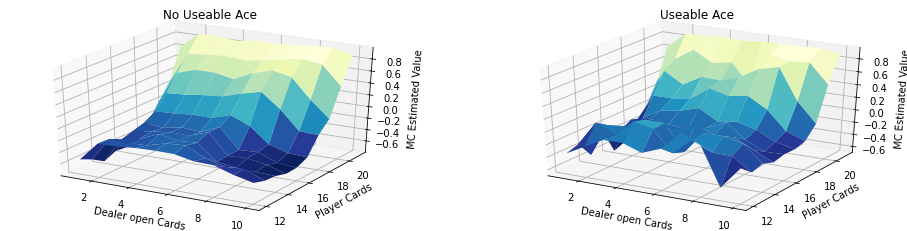

In [13]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 4), subplot_kw={'projection': '3d'})

ax0.plot_surface(X, Y, no_usable_ace, cmap=plt.cm.YlGnBu_r)
ax0.set_xlabel('Dealer open Cards')
ax0.set_ylabel('Player Cards')
ax0.set_zlabel('MC Estimated Value')
ax0.set_title('No Useable Ace')

ax1.plot_surface(X, Y, usable_ace, cmap=plt.cm.YlGnBu_r)
ax1.set_xlabel('Dealer open Cards')
ax1.set_ylabel('Player Cards')
ax1.set_zlabel('MC Estimated Value')
ax1.set_title('Useable Ace')
    
plt.show()